In [22]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [23]:
# Importing and splitting data
def load_data(categories=4):
    # get random categories
    dir_list = []
    for dirs in os.listdir("caltech-101/101_ObjectCategories/"):
        dir_list.append(os.path.join("caltech-101/101_ObjectCategories", dirs))
        
    random.Random(5).shuffle(dir_list)      
    random_categories = dir_list[:categories] 
    
    data = []
    
    #get images from each category
    for category in random_categories:
        # get files in each category
        for file in os.listdir(category):
            im = cv2.imread(os.path.join(category, file))
            gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            data.append((gray, category.split("/")[-1]))
            
    # shuffle data and split into train and test
    random.Random(4).shuffle(data)
    test = data[:int(len(data)//2)]
    train = data[int(len(data)//2)+1:]
    
    return train, test
        
train, test = load_data()

print(train[0])
print(len(test))

(array([[145, 145, 146, ..., 166, 166, 167],
       [192, 192, 192, ..., 228, 228, 229],
       [183, 184, 184, ..., 213, 213, 214],
       ...,
       [182, 129, 190, ..., 198, 209, 254],
       [224, 170, 221, ..., 190, 212, 250],
       [223, 170, 213, ..., 156, 183, 230]], dtype=uint8), 'Faces_easy')
283


In [24]:
# def load_data(categories=4):
#     #get 5 random categories
#     dir_list = []
#     for dirs in os.listdir("caltech-101/101_ObjectCategories/"):
#         dir_list.append(os.path.join("caltech-101/101_ObjectCategories", dirs))
        
#     random.Random(5).shuffle(dir_list)      
#     random_categories = dir_list[:categories] 
    
#     data = {}
    
#     # get images for each category
#     for category in random_categories:
#         # get files in each category
#         for file in os.listdir(category):
#             im = cv2.imread(os.path.join(category, file))
#             key = category.split("/")[-1]
            
#             data[key] = data.get(key, []) + [im]
        
#     # split into train and test  
#     train = {} 
#     test = {} 
    
#     for key in data.keys():
#         random.Random(5).shuffle(data[key])
#         train[key] = data[key][:int(len(data[key])/2)]
#         test[key] = data[key][int(len(data[key])/2):]
    
#     return train, test
        
# train, test = load_data()

# print(train.keys())
# print(test.keys())
# print(len(train['wild_cat']))
# print(len(test['wild_cat']))

In [25]:
# Importing package for KMeans algorithm
from sklearn.cluster import KMeans

# Feature extraction using SIFT
def extract_features(data):
    
    features = np.zeros((0, 128))
    
    for i in range(len(data)):
        im = data[i] # [0]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        features = np.vstack((features, des))
                
    return features

# Running k_means and getting clusters
def cluster_features(features, k=250):
    
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(features)
    return kmeans.cluster_centers_
    
features = extract_features(train)
clusters = cluster_features(features)

# print(f"FEATURES:\n{features}")
# print(f"CLUSTERS:\n{clusters}")

error: OpenCV(4.5.4-dev) :-1: error: (-5:Bad argument) in function 'detectAndCompute'
> Overload resolution failed:
>  - image is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'image'


In [ ]:
def bag_of_words(clusters, data):
    # gets bag of words for each image in data
    all_bags = []
    for i in range(len(data)):
        im = data[i] # [0]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        
        # get histogram of clusters / bag of words for one image
        bag_of_words = np.zeros(len(clusters))
        for d in des:
            distances = np.linalg.norm(clusters - d, axis=1)
            bag_of_words[np.argmin(distances)] += 1
        all_bags.append(bag_of_words)
        
    return all_bags

bags = bag_of_words(clusters, train)

error: OpenCV(4.5.4-dev) :-1: error: (-5:Bad argument) in function 'detectAndCompute'
> Overload resolution failed:
>  - image is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'image'


<BarContainer object of 250 artists>

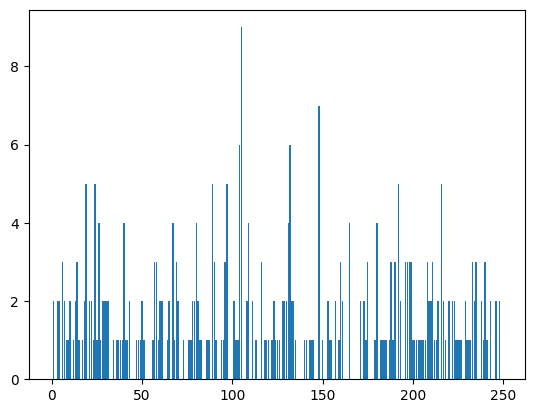

In [ ]:
#histogram of bag of words for first image
plt.bar(np.arange(0, len(clusters)), bags[1])

In [27]:
import pandas as pd

def make_table():
    #file name, true category, training/test set, word histogram
    table = {"file_name" : [],
             "category" : [],
             "test-train" : [],
             "im" : [],
             "hist": []}
    
    #get categories
    dir_list = []
    for dirs in os.listdir("caltech-101/101_ObjectCategories/"):
        dir_list.append(os.path.join("caltech-101/101_ObjectCategories", dirs))
        
    random.Random(5).shuffle(dir_list)      
    random_categories = dir_list[:4] 

    
    #get images from each category
    for category in random_categories:
        # get files in each category
        for file in os.listdir(category):
            table["file_name"] = table.get("file_name", []) + [file]
            table["category"] = table.get("category", []) + [category.split("/")[-1]]
            im = cv2.imread(os.path.join(category, file))
            gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            table["im"] = table.get("im", []) + [gray]
            
    # shuffle data and split into train and test
    test_train = []
    
    if len(table.get("category")) % 2 == 0:
        half = int(len(table.get("category")) / 2)
        test_train = ["test"] * half + ["train"] * half
    else:
        half = int(len(table.get("category")) / 2)
        test_train = ["test"] * half + ["train"] * (half + 1)

    random.Random(5).shuffle(test_train)
    
    table["test-train"] = test_train
        
    return table
    
table = make_table()

train = []
test = []

for i in range(len(table["test-train"])):
    test_train = table["test-train"]
    im = table["im"]
    
    if test_train[i] == "test":
        test.append(im[i])
    elif test_train[i] == "train":
        train.append(im[i])
        
# get vocabulary
#print(train)

features = extract_features(train)
clusters = cluster_features(features)

table["hist"] = bag_of_words(clusters, table["im"])

In [43]:
df_table = pd.DataFrame(table)
df_table

,file_name,category,test-train,im,hist
0,image_0020.jpg,wild_cat,train,"[[201, 201, 201, 201, 201, 201, 201, 201, 204,...","[4.0, 6.0, 1.0, 5.0, 3.0, 1.0, 1.0, 3.0, 1.0, ..."
1,image_0004.jpg,wild_cat,test,"[[95, 46, 66, 57, 79, 42, 76, 123, 111, 124, 1...","[1.0, 17.0, 2.0, 13.0, 15.0, 0.0, 16.0, 9.0, 5..."
2,image_0026.jpg,wild_cat,test,"[[65, 65, 80, 105, 120, 119, 117, 120, 124, 12...","[5.0, 1.0, 2.0, 2.0, 3.0, 0.0, 4.0, 3.0, 1.0, ..."
3,image_0034.jpg,wild_cat,test,"[[17, 15, 12, 10, 9, 9, 9, 9, 15, 14, 13, 13, ...","[4.0, 0.0, 2.0, 5.0, 0.0, 1.0, 5.0, 4.0, 3.0, ..."
4,image_0003.jpg,wild_cat,test,"[[29, 34, 40, 44, 45, 42, 37, 34, 32, 32, 32, ...","[1.0, 8.0, 4.0, 3.0, 5.0, 0.0, 6.0, 7.0, 0.0, ..."
...,...,...,...,...,...
561,image_0029.jpg,crocodile,train,"[[104, 103, 103, 102, 102, 101, 101, 101, 97, ...","[0.0, 2.0, 3.0, 3.0, 1.0, 1.0, 2.0, 5.0, 1.0, ..."
562,image_0047.jpg,crocodile,test,"[[26, 38, 55, 65, 73, 82, 88, 90, 88, 86, 89, ...","[0.0, 2.0, 3.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, ..."
563,image_0032.jpg,crocodile,train,"[[41, 28, 18, 21, 27, 26, 24, 24, 31, 27, 30, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, ..."
564,image_0017.jpg,crocodile,train,"[[99, 96, 93, 92, 92, 92, 91, 89, 86, 86, 85, ...","[0.0, 2.0, 1.0, 2.0, 3.0, 0.0, 2.0, 1.0, 0.0, ..."
